# Investigation of how many observations in test set needed for good results

Still uses the same test sets, so loss values are comparable across models and with benchmark models

## First with most recent observations as test data

In [141]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch, random, os, numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = False
SEED = 1234
DEVICE = "mps"
DOW = True

dataset= get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, dow = DOW)
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
else:
    if WEEKS:
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
    else: 
        train_idcs, test_idcs = range(2133), range(2133, dataset.__len__()) # 2844 total obs - 711 test, still 25% even without random split dataset.__len__(), 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        
## Define generator so sampling during training is deterministic and reproducible
test_sampler = SS(test_idcs)
test_loader = DataLoader(dataset, batch_size=len(test_idcs), sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

set_seeds(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


If the architecture is final, could just import from NowcastPNN

In [16]:
%load_ext autoreload
%autoreload 3
from NowcastPNN import NowcastPNNDOW
from train_utils import train, EarlyStopper

n_training = [500, 1000, 1500, 2000] # originally 2133 as training + val
for n in n_training:
    set_seeds(SEED)
    train_idcs = range((2133-n), 2133) # take recent 'n' observations
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    g = torch.Generator()
    g.manual_seed(SEED)
    temp_train_sampler, temp_val_sampler= SRS(train_idcs, generator=g), SRS(val_idcs)
    temp_train_loader, temp_val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=temp_train_sampler), DataLoader(dataset, batch_size=len(val_idcs), sampler=temp_val_sampler, shuffle=False)
    #regen_data()
    print(f"##################### Number training data points: {n} #####################")
    ## Redefine training and validation indices, and define train and validation loaders
    #regen_data() # reset samplers so each training run is reproducible
    early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, random_split=RANDOM_SPLIT, dow = DOW, n_training = n)
    nowcast_pnn = NowcastPNNDOW(past_units=PAST_UNITS, max_delay=MAX_DELAY, embedding_dim=10)
    train(nowcast_pnn, num_epochs=500, train_loader=temp_train_loader, val_loader=temp_val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE, dow = DOW)
   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
##################### Number training data points: 2133 #####################
Epoch 1 - Train loss: 2.62e+05 - Val loss: 2.29e+06 - ES count: 0
Epoch 2 - Train loss: 2.54e+05 - Val loss: 2.33e+06 - ES count: 1
Epoch 3 - Train loss: 2.51e+05 - Val loss: 2.08e+06 - ES count: 0
Epoch 4 - Train loss: 2.46e+05 - Val loss: 1.96e+06 - ES count: 0
Epoch 5 - Train loss: 2.41e+05 - Val loss: 1.95e+06 - ES count: 0
Epoch 6 - Train loss: 2.38e+05 - Val loss: 1.9e+06 - ES count: 0
Epoch 7 - Train loss: 2.34e+05 - Val loss: 1.86e+06 - ES count: 0
Epoch 8 - Train loss: 2.29e+05 - Val loss: 1.8e+06 - ES count: 0
Epoch 9 - Train loss: 2.26e+05 - Val loss: 1.75e+06 - ES count: 0
Epoch 10 - Train loss: 2.2e+05 - Val loss: 1.74e+06 - ES count: 0
Epoch 11 - Train loss: 2.15e+05 - Val loss: 1.68e+06 - ES count: 0
Epoch 12 - Train loss: 2.09e+05 - Val loss: 1.56e+06 - ES count: 0
Epoch 13 - Train loss: 2.04e+05 - Val loss

In [151]:
from metrics import evaluate_PIs, pnn_PIs
set_seeds(SEED) # Reproducible results
pnn_coverages, pnn_picas, pnn_wis, pnn_is_decomp = [], [], [], []
n_training_plot = [500, 1000, 1500, 2000, 2133]
for n in n_training_plot:
    print(f"##################### Number training data points: {n} #####################")
    if n == 2133:
        nowcast_pnn.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}"))
    else:
        nowcast_pnn.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}-{n}"))
    temp_levels_pnn = pnn_PIs(nowcast_pnn, test_loader, random_split = RANDOM_SPLIT, save=False, dow = DOW) # think about how save with name
    temp_pnn_dict = evaluate_PIs(temp_levels_pnn, test_loader)
    pnn_coverages.append(temp_pnn_dict["coverages"])
    pnn_picas.append(temp_pnn_dict["pica"])
    pnn_wis.append(temp_pnn_dict["wis"])
    pnn_is_decomp.append(temp_pnn_dict["is"])

##################### Number training data points: 500 #####################
Actual coverage per level | 5%: 0.14 | 10%: 0.98 | 25%: 1.83 | 50%: 5.06 | 75%: 10.97 | 90%: 16.88 | 95%: 21.1 |
PICA: 0.41862567811934903
WIS: 5168.842438206489
IS: under = 13072.175472671359 | spread = 67.10722824994977 | over = 175.13419625011892 | total = 13314.416897171428
##################### Number training data points: 1000 #####################
Actual coverage per level | 5%: 2.39 | 10%: 4.22 | 25%: 12.8 | 50%: 27.29 | 75%: 43.18 | 90%: 61.74 | 95%: 68.64 |
PICA: 0.1853526220614828
WIS: 864.3690353454348
IS: under = 1729.911294880426 | spread = 490.5117741611412 | over = 260.63986384150724 | total = 2481.062932883074
##################### Number training data points: 1500 #####################
Actual coverage per level | 5%: 3.52 | 10%: 6.61 | 25%: 15.75 | 50%: 36.29 | 75%: 58.93 | 90%: 74.82 | 95%: 83.12 |
PICA: 0.10136628491058872
WIS: 247.19426373158637
IS: under = 126.71077012738127 | spread = 37

## Plot IS, WIS and coverages over time

All in one plot, 3x1, then say for randomly split data is in appendix, looks identical

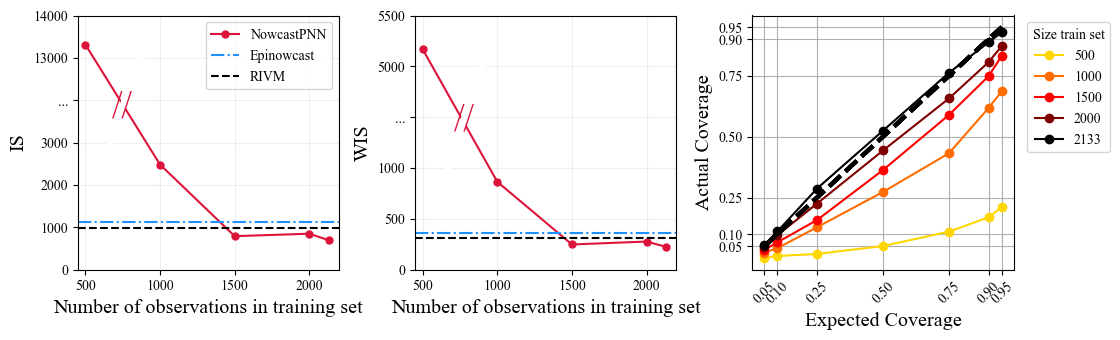

In [154]:
from plotting import plot_training_size_is_wis_covs
plot_training_size_is_wis_covs(n_training=n_training_plot, pnn_is_decomp=pnn_is_decomp, pnn_wis=pnn_wis, pnn_coverages=pnn_coverages, save = True, random_split = True)

# Fit with randomly split test set, take subset of training data

In [155]:
RANDOM_SPLIT = True

all_idcs_rand = range(dataset.__len__())
train_idcs_rand_total, test_idcs_rand = TTS(all_idcs_rand, test_size=0.25, shuffle=True, random_state=SEED)
train_idcs_rand, val_idcs_rand = TTS(train_idcs_rand_total, test_size=0.25, shuffle=True, random_state=SEED)

test_sampler_rand = SS(test_idcs_rand)
test_loader_rand = DataLoader(dataset, batch_size=len(test_idcs_rand), sampler=test_sampler_rand, shuffle=False)

In [145]:
n_training = [500, 1000, 1500, 2000] # originally 2133 as training + val
for n in n_training:
    set_seeds(SEED)
    train_idcs_rand = np.random.choice(train_idcs_rand_total, n, replace = False)
    train_idcs_rand, val_idcs_rand = TTS(train_idcs_rand, test_size=0.25, shuffle=True, random_state=SEED)
    g = torch.Generator()
    g.manual_seed(SEED)
    temp_train_sampler, temp_val_sampler= SRS(train_idcs_rand, generator=g), SRS(val_idcs_rand)
    temp_train_loader, temp_val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=temp_train_sampler), DataLoader(dataset, batch_size=len(val_idcs_rand), sampler=temp_val_sampler, shuffle=False)
    print(f"##################### Number training data points: {n} #####################")
    early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, random_split=RANDOM_SPLIT, dow = DOW, n_training = n)
    nowcast_pnn_rand = NowcastPNNDOW(past_units=PAST_UNITS, max_delay=MAX_DELAY, dropout_probs=[0.3, 0.1]) # better probs for randomly split
    train(nowcast_pnn_rand, num_epochs=500, train_loader=temp_train_loader, val_loader=temp_val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE, dow = DOW)
   

##################### Number training data points: 500 #####################
Epoch 1 - Train loss: 2.56e+05 - Val loss: 4.54e+05 - ES count: 0
Epoch 2 - Train loss: 2.53e+05 - Val loss: 4.5e+05 - ES count: 0
Epoch 3 - Train loss: 2.48e+05 - Val loss: 4.44e+05 - ES count: 0
Epoch 4 - Train loss: 2.48e+05 - Val loss: 4.51e+05 - ES count: 1
Epoch 5 - Train loss: 2.45e+05 - Val loss: 4.55e+05 - ES count: 2
Epoch 6 - Train loss: 2.45e+05 - Val loss: 4.63e+05 - ES count: 3
Epoch 7 - Train loss: 2.43e+05 - Val loss: 4.64e+05 - ES count: 4
Epoch 8 - Train loss: 2.42e+05 - Val loss: 4.54e+05 - ES count: 5
Epoch 9 - Train loss: 2.42e+05 - Val loss: 4.44e+05 - ES count: 6
Epoch 10 - Train loss: 2.4e+05 - Val loss: 4.42e+05 - ES count: 0
Epoch 11 - Train loss: 2.39e+05 - Val loss: 4.39e+05 - ES count: 0
Epoch 12 - Train loss: 2.39e+05 - Val loss: 4.31e+05 - ES count: 0
Epoch 13 - Train loss: 2.39e+05 - Val loss: 4.21e+05 - ES count: 0
Epoch 14 - Train loss: 2.38e+05 - Val loss: 4.21e+05 - ES count

## Evaluate models

In [156]:
from metrics import evaluate_PIs, pnn_PIs
set_seeds(SEED) # Reproducible results
pnn_coverages_rand, pnn_picas_rand, pnn_wis_rand, pnn_is_decomp_rand = [], [], [], []
n_training_plot = [500, 1000, 1500, 2000, 2133]
for n in n_training_plot:
    set_seeds(SEED)
    print(f"##################### Number training data points: {n} #####################")
    if n == 2133:
        nowcast_pnn_rand.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}"))
    else:
        nowcast_pnn_rand.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}-{n}"))
    temp_levels_pnn = pnn_PIs(nowcast_pnn_rand, test_loader_rand, random_split = RANDOM_SPLIT, save=False, dow = DOW) # think about how save with name
    temp_pnn_dict = evaluate_PIs(temp_levels_pnn, test_loader_rand)
    pnn_coverages_rand.append(temp_pnn_dict["coverages"])
    pnn_picas_rand.append(temp_pnn_dict["pica"])
    pnn_wis_rand.append(temp_pnn_dict["wis"])
    pnn_is_decomp_rand.append(temp_pnn_dict["is"])

##################### Number training data points: 500 #####################
Actual coverage per level | 5%: 3.09 | 10%: 5.91 | 25%: 16.46 | 50%: 35.58 | 75%: 50.49 | 90%: 62.73 | 95%: 69.62 |
PICA: 0.15159734779987946
WIS: 346.41732520637805
IS: under = 358.6061426421185 | spread = 362.6814396222624 | over = 328.63124877359826 | total = 1049.918831037979
##################### Number training data points: 1000 #####################
Actual coverage per level | 5%: 5.77 | 10%: 10.27 | 25%: 25.74 | 50%: 47.96 | 75%: 72.43 | 90%: 85.65 | 95%: 91.28 |
PICA: 0.020634920634920638
WIS: 201.4363875495897
IS: under = 184.8143918163905 | spread = 345.2715591721921 | over = 109.25672596869575 | total = 639.3426769572783
##################### Number training data points: 1500 #####################
Actual coverage per level | 5%: 5.2 | 10%: 11.11 | 25%: 23.07 | 50%: 43.88 | 75%: 62.31 | 90%: 73.42 | 95%: 77.78 |
PICA: 0.07980711271850512
WIS: 243.30425482942783
IS: under = 226.64807118593475 | sprea

## Plot metrics over n training - new plot without cut

probably need to specify whether to cut axis or not and where, maybe make other plot for this

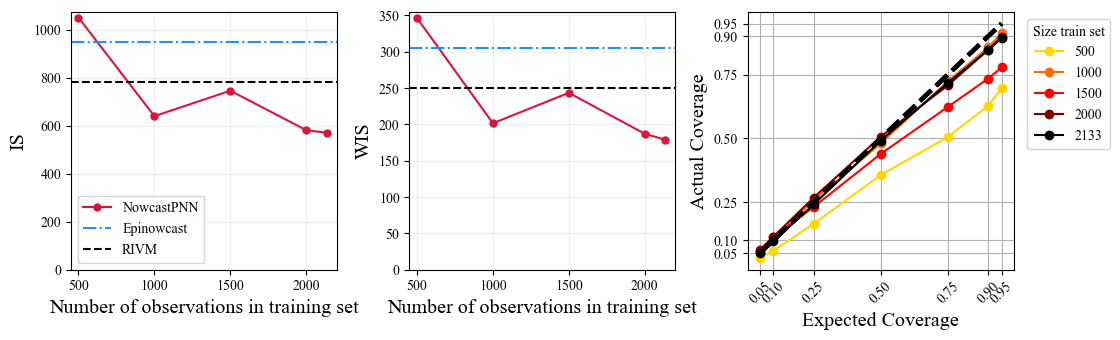

In [159]:
from plotting import plot_training_size_is_wis_covs_rand
plot_training_size_is_wis_covs_rand(n_training=n_training_plot, pnn_is_decomp=pnn_is_decomp_rand, pnn_wis=pnn_wis_rand, pnn_coverages=pnn_coverages_rand, save = True)